# The Probability Distribution and House Edge in CSGOCrash

## Note

Hi, this is my first time writing something like this and there will be a boatload of mistakes, in formatting, content, and methodology. I will really appreciate any feedback on how to improve this report. Just send me an [email](cjyoung@ucsd.edu) and I'll probably read it within a week.

## Introduction

In the last decade, Counter Strike: Global Offensive, or CS:GO, has been a rising star in the competitive first-person shooter game genre. In 2021 alone, the estimated amount of prize money earned in competitive tournaments rose to 21.17 million USD, making it the first-person shooter game with the highest cumulative prize pool that year [(Statistica.com)](https://www.statista.com/statistics/807908/csgo-tournament-prize-pool/). From its rise in popularity as an e-sport arose an active gambling scene, which takes advantage of the game's built-in cash shop to bypass most regulations regarding gambling. Within the game, a player can purchase "lootboxes", items which a player can open for chances at rare in-game cosmetics, such as weapon skins. These items can then be sold on an open market hosted on Steam, a video game platform owned by Valve, the creators of CS:GO. Since the money earned this way cannot be withdrawn directly as cash, video game items are not yet subject to legal regulations against gambling, and hence can be used by anyone, including minors, as stakes in an online bet. Though this began as a way to gamble on competition results, online CS:GO gambling has greatly expanded its variety, including games such as roulette, slot machines, and CSGOCrash.

CSGOCrash is unique in how, as its name suggests, it exists almost entirely in the context of CS:GO skin gambling. The player would deposit a game item, or some online currency that can be converted into items, as their bet. Then, a number starting from 1 would increase exponentially in speed, stopping "randomly" at some number. If the player cashes out before the number stops, the number acts as a multiplier, and the player earns back what they bet multiplied by the number. If the player has not cashed out by then, they lose the bet.

In the following report, I will conduct an analysis of the CSGOCrash game hosted on WTFskins.com, a popular CS:GO gambling site. The site provides a history of all its prior gambling results, of which I have compiled 46549 in the file ```input.txt```. I hypothesize that the data will have two features. First, the wide majority of the data is drawn from a Type I Pareto probability distribution with a scale and shape parameter equal to 1. Second, a number of results were drawn from a different probability distribution which heavily favors significantly smaller numbers.

## Data
The data consists of 46550 rows with one number per row in the file ```input.txt```. Each row represents a gambling result on WTFSkins.com for CSGOCrash which were scraped in the summer of 2020. Due to my inexperience at the time, I did not include the exact timestamps or IDs of each result at the time, but they should not be relevant during the analysis as each point is assumed to be independent (though by my hypothesis, not identically distributed). When working with new data generated by ```webScrape.py```, the script I wrote to extract the data from the website, either the first data point should be removed, as shown in the code below, or the first row should be altered such that the format matches the others. This is required since my script uses a format different from the others for the first row, and I have chosen to solve this problem using the [Ostrich Algorithm](https://en.wikipedia.org/wiki/Ostrich_algorithm) as it no longer poses a problem to me at the time of writing this report.

In [1]:
# Importing data
from decimal import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.optimize import fsolve

# extracts data from input.txt into a list, removes first line since element doesn't follow form
f = open('./input.txt', "r")
getcontext().prec = 4
data = f.readlines() # contains list of all data points in string form
del data[0] # REMOVE THIS LINE ONLY IF THE FIRST ROW IN input.txt IS CHANGED BY HAND TO MATCH THE OTHERS
f.close()

# converts data into list of floatsL rather than strings
float_data = []
for line in data:
    if line == data[len(data) - 1]:
        continue
    float_data.append(float(line.split(" ")[2].split("\n")[0]))
data = float_data
data = np.array(data) # Convert data into Numpy array

## Visualization
First, let's take a look at what the data looks like as well as compare it to the Pareto distribution. If my hypothesis is correct, the cumulative density of the data points as the x-axis increases should follow the Pareto distribution, albeit be slightly higher as *x* increases due to the house edge.

In [2]:
# Cumulative distribution function of a Type I Pareto Distribution with parameters equal to 1
def pareto_cdf(x):
    return 1-1/x

# Probability distribution function of a Pareto Distribution with same parameters
def pareto_pdf(x):
    return 1/x

(1.0, 10.0)

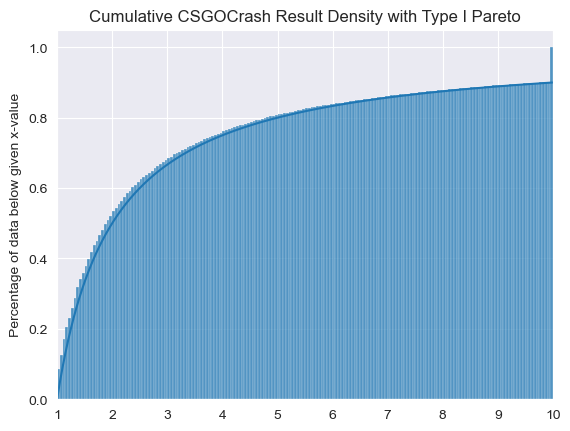

In [3]:
# Copy the data and apply an upper limit so that the histogram doesn't stretch out too much
data_one_to_ten = data.copy()
data_one_to_ten[data_one_to_ten > 10] = 10

sns.histplot(data_one_to_ten, kde=False, cumulative=True, stat='density', binwidth=0.05)
plt.plot(np.arange(1, 10, 0.01), pareto_cdf(np.arange(1, 10, 0.01)))
plt.title("Cumulative CSGOCrash Result Density with Type I Pareto")
plt.ylabel("Percentage of data below given x-value")
plt.xlim(1, 10)

We can see from the above histogram that the cumulative distribution of the data follows very closely with the cdf of the Type I Pareto Distribution. Let us zoom in some more towards to left tail to see if the data distribution lies above the Pareto distribution.

(1.0, 4.0)

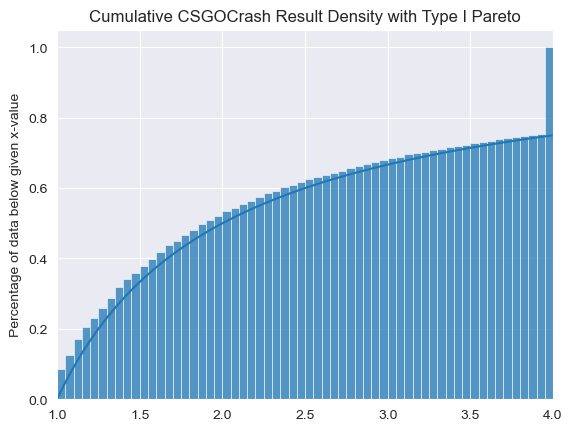

In [4]:
# Same process as before, but with 4 as the upper limit
data_one_to_four = data.copy()
data_one_to_four[data_one_to_ten > 4] = 4

sns.histplot(data_one_to_four, kde=False, cumulative=True, stat='density', binwidth=0.05)
plt.plot(np.arange(1, 10, 0.01), pareto_cdf(np.arange(1, 10, 0.01)))
plt.title("Cumulative CSGOCrash Result Density with Type I Pareto")
plt.ylabel("Percentage of data below given x-value")
plt.xlim(1, 4)

It appears that the gambling results do follow the trend that I've hypothesized, where some of the data is drawn from a different probability with a very high density near 1. When we take a closer look at the data it is clear why this occurs.

In [5]:
df_data = pd.DataFrame(data)
df_data.describe()

,0
count,46549.000000
mean,12.429668
std,425.397198
min,0.000000
25%,1.280000
50%,1.910000
75%,3.870000
max,67558.300000


There is a clear anomaly in the above description. Zero? Why is there a zero when the multiplier begins at one? I've checked the website, and there does exist "0" results in the logs provided. I also observe that occasionally, the gambling number does default to "0" when the game stops immediately, and no one receives a payout. How rare does this phenomenon occur?

In [6]:
print("Total number of zeroes in the data: {}".format(len(data[data == 0])))
print("Total number of zeroes in the data as a percentage: {}".format(len(data[data == 0])/len(data)))

Total number of zeroes in the data: 1839
Total number of zeroes in the data as a percentage: 0.03950675632129584


We can see now that of every 100 gambles, almost 4 result in a guaranteed loss regardless of the number the player chooses to cash out at. It is also clear that these points are not drawn from the Pareto distribution, as it is impossible for number less than or equal to one to be drawn. It is most likely that these points are drawn from a distribution with a sample space of $\{0\}$. With this in mind, we should see that the cumulative data density matches the cumulative Pareto distribution function once the zeroes are removed.

(1.0, 4.0)

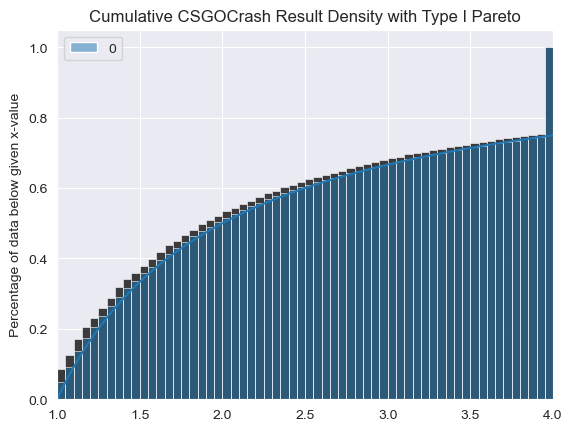

In [7]:
from matplotlib import colors

# Removes zeroes from DataFrame
data_one_to_four_adjusted = df_data.loc[(df_data != 0).any(axis=1)]

# Same process as before, but with 4 as the upper limit
data_one_to_four_adjusted = np.array(data_one_to_four_adjusted)
data_one_to_four_adjusted[data_one_to_four_adjusted > 4] = 4

sns.histplot(data_one_to_four, kde=False, cumulative=True, stat='density', binwidth=0.05, color=colors.to_hex('#000000'))
sns.histplot(data_one_to_four_adjusted, kde=False, cumulative=True, stat='density', binwidth=0.05, color=colors.to_hex('#0000CD'))
plt.plot(np.arange(1, 10, 0.01), pareto_cdf(np.arange(1, 10, 0.01)))
plt.title("Cumulative CSGOCrash Result Density with Type I Pareto")
plt.ylabel("Percentage of data below given x-value")
plt.xlim(1, 4)

In the above graph, the blue bars represent the density of values when the zeroes are removed, the white bars represent the data before removal, and the line represents the Pareto CDF. From this, we can see that after the zeroes are# removed, the data does indeed follow very closely with the Pareto distribution. Next, we will try to confirm this using the Cramer-von Mises Criterion.

In [8]:
# Function for the Cramer-von Mises Criterion
# Parameters
# ----------------------------
# x: an array of numbers containing a list of data points

def w(x):
    n = len(x)
    add = np.arange(1, 2*n+1, 2)
    add = add / (2*n)
    w_squared = np.square(add - np.squeeze(pareto_cdf(x)))
    return w_squared

def cramer_test_stat(x):
    x = np.squeeze(x)
    x = np.sort(x)
    n = len(x)
    w_squared = w(x)
    return 1/(12*n) + np.sum(w_squared)

# adjust data to remove zeroes
data_no_zeroes = pd.DataFrame(data)
data_no_zeroes = data_no_zeroes.loc[(data_no_zeroes != 0).any(axis=1)]
print("Cramer-von Mises Test Statistic: {}", cramer_test_stat(data_no_zeroes))

Cramer-von Mises Test Statistic: {} 0.3206756497168071


This was a very unexpected result. Despite how well the data seems to fit the distribution, it still far exceeds critical values assuming $\alpha=0.01$ [(Porter, Coleman, Moore, 1994)](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=126681). The answer to this lies in a unique feature of the data. Note that each point appears to be rounded to the hundredth decimal place, which would not occur naturally. It appears that when calculating gambling results, the game on WTFSkins.com in particular tends to round the values it acquires down to the hundredth value. Next, I'll try to compensate for this rounding by generating values using the ```pareto``` function from the ```scipy.stats``` library, truncating the value such that only smaller than the hundredth value are left, and appending the smaller values onto the CSGOCrash dataset.

In [10]:
from scipy.stats import pareto

simulation = []
data_no_zeroes = np.squeeze(data_no_zeroes)
for i in range(1000): # Conducting multiple trials to be certain of the results
    r = pareto.rvs(1, size=len(data_no_zeroes))
    r = r*100
    r = r - np.floor(r)
    r = r/100
    simulation.append(cramer_test_stat(data_no_zeroes + r))
print(np.average(simulation))

0.052397905923675006


## Conclusion

With the artificial randomness added to compensate for rounding on the side of the website. We can be very confident in saying that either I made a mistake (which is *very likely*) or that WTFSkins' CSGOCrash game draws around 96% its data from a Type I Pareto distribution with parameters equal to 1 and sets 4% of its results to equal 0.